In [1]:
import random

from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from sklearn.preprocessing import normalize
import torch
from torch import nn
from torchvision.models import inception_v3
import torchvision

In [2]:
import vendi_score
from vendi_score import vendi, image_utils, data_utils

### Load data

Load the CIFAR100 dataset. Each example is stored in a utility class called `data_utils.Example` to keep track of features and metadata. The image is stored in Pillow format in `example.x`.

Files already downloaded and verified
Label: mountain Features names: dict_keys(['pixels'])


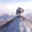

In [3]:
cifar_examples = image_utils.get_cifar100("samples/cifar100/original", split="test")
e = cifar_examples[0]
print("Label:", e.labels["y"], "Features names:", e.features.keys())
e.x

### Get image embeddings

Add embeddings from the `pool_2048` block of a pretrained Inception v3 model.

In [4]:
device = torch.device("cuda")
embeddings = image_utils.get_inception_embeddings(
    [e.x for e in cifar_examples],
    batch_size=64,
    device=torch.device("cuda")
)
for e, emb in zip(cifar_examples, embeddings):
    e.features["inception"] = emb

### Which CIFAR100 categories are most diverse?

See which CIFAR100 categories get the highest and lowest diversity scores using two different similarity functions: Inception similarity, defined as the cosine similarity between Inception embeddings, and pixel similarity, the cosine similarity between pixel vectors.

In [5]:
categories = sorted(set(e.labels["y"] for e in cifar_examples))
category_groups = {c: data_utils.Group(c, []) for c in categories}
for e in cifar_examples:
    category_groups[e.labels["y"]].examples.append(e)
groups = list(category_groups.values())

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
for group in category_groups.values():
    for feature in ("inception", "pixels"):
        X = np.stack([e.features[feature] for e in group.examples], 0)
        group.metrics[f"{feature.title()} vNd"] = vendi.score_X(X)

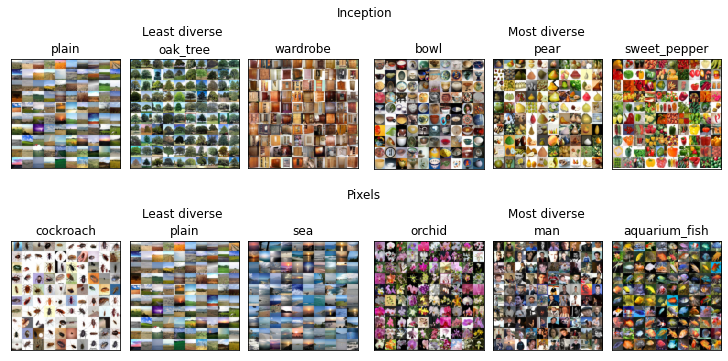

In [7]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, (feature, subfig) in enumerate(zip(("Inception", "Pixels"), subfigs)):
    subfig.suptitle(feature.title())
    order = np.argsort([g.metrics[f"{feature} vNd"] for g in groups])
    left, right = subfig.subfigures(nrows=1, ncols=2)
    left.suptitle("Least diverse")
    axs = left.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        group = groups[order[col]]
        ax.set_title(group.name)
        image_utils.plot_images([e.x for e in group.examples][:100],
                                cols=10, ax=ax)
    right.suptitle("Most diverse")        
    axs = right.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        group = groups[order[-3 + col]]
        ax.set_title(group.name)
        image_utils.plot_images([e.x for e in group.examples][:100],
                                cols=10, ax=ax)
plt.show()

### Detecting mode dropping

We'll create a mode dropping scenario by picking 10 categories and sampling 10 datasets, $S_1, \ldots, S_{10}$, each $S_i$ containing 100 images selected uniformly from the first $i$ categories. The Vendi score is compared to IntDiv: $\mathrm{IntDiv}(K) = 1 - \frac{1}{n^2}\sum_{i, j}K_{ij}$ for an $n \times n$ similarity matrix $K$.

In [8]:
random.seed(0)
cats = random.sample(categories, 10)
label_to_examples = {group.name: group.examples for group in groups}
mode_dropping_groups = data_utils.mode_dropping_groups(label_to_examples, cats, N=100)

In [9]:
for group in mode_dropping_groups:
    for feature in ("inception", "pixels"):
        X = np.stack([e.features[feature] for e in group.examples], 0)
        X = normalize(X)
        group.Ks[feature] = K = X @ X.T
        group.metrics[f"{feature.title()} vNd"] = vendi.score_K(K)
        group.metrics[f"{feature.title()} IntDiv"] = vendi.intdiv_K(K)

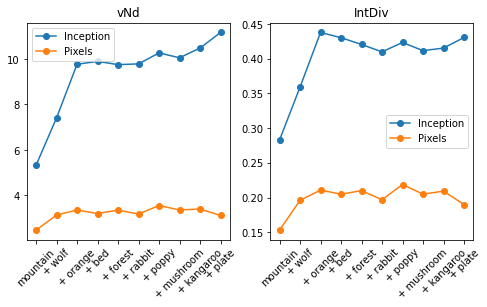

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for ax, metric in zip(axes, ("vNd", "IntDiv")):
    ax.set_title(metric)
    for feature in ("Inception", "Pixels"):
        ax.plot([g.name for g in mode_dropping_groups],
                [g.metrics[f"{feature} {metric}"] for g in mode_dropping_groups],
                marker="o",
                label=feature.title())
    xticks = [cats[0]] + [f"+ {c}" for c in cats[1:]]
    ax.set_xticks([g.name for g in mode_dropping_groups])
    ax.set_xticklabels(xticks, rotation=45)
    ax.legend()
plt.show()

Both Vendi scores are correlated with the number of classes represented in the sample, but Inception similarity makes stronger distinctions between classes in this dataset, leading to a stronger correlation. The results increase the most when we add a class that has high internal diversity and is very different from any of the other classes in the sample, like `poppy`.

IntDiv increases linearly between $S_1$ and $S_3$, but then no longer is a very good measurement of the number of classes.